# Pipeline for analysing open clusters based on Gaia DR2 data

## 1 - Libraries

In [1]:
#%matplotlib notebook

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy
import astropy.stats as ap

from math import pi, ceil, floor
from astropy import units
from astropy.table import Table
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from IPython.display import display, HTML

## 2 - Query Gaia DR2 Catalog

In [36]:
# Gaia DR2 catalog on VizieR
# see https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=I/345/gaia2
cat = 'I/345/gaia2'
cols = ['_r', 'DR2Name', 'RAdeg', 'DEdeg', 'Plx', 'e_Plx', 'pmRA', 'pmDE', 'Gmag', 'BP-G']
row_lim = 1000
timeout = 600
uns = [['h','m','s'],['d','m','s']]

#Query the GDR2 data for one cluster
def query(name, ra_deg, de_deg, rad_deg, filter_map, max_stars = 1000):
    print("Querying VizieR for %s ..." % name)
    coo = SkyCoord(ra = ra_deg*units.degree, dec = de_deg*units.degree, frame = 'icrs')
    viz = Vizier(columns = cols, column_filters = filter_map, row_limit = row_lim, timeout = timeout)
    viz_res = viz.query_region(coo, radius = rad_deg*units.degree, catalog = cat)
    if viz_res == None or len(viz_res) == 0:
        print(viz_res)
        return pd.DataFrame() #Empty Dataframe
    df = viz_res[0].to_pandas()
    df = df.set_index('DR2Name')
    df = df.sort_values(by='Gmag')
    df = df[:max_stars]
    df = df.sort_values(by='_r')
    if not df.empty:
        #display(df.head())
        display(df.describe())
    else:
        print('Empty dataframe! - try again with another set of parameters')
    return df

# convert sexagesimal to decimal coordinates
def convert(_ra, _dec, diam):
    comps = list(zip(_ra.split(' '),uns[0]))
    ra = ''.join([item for sublist in comps for item in sublist])
    comps = list(zip(_dec.split(' '),uns[1]))
    dec = ''.join([item for sublist in comps for item in sublist])
    c = SkyCoord(ra, dec, frame='icrs')
    return c.ra.value, c.dec.value, diam / 120

filters = {'Plx' : '-0.25..2.75', 'e_Plx' : '<0.5', 'pmRA' : '-15..15', 'pmDE' : '-15..15', 'Gmag' : '<16'}

# PUT THE INPUT HERE IF YOU WANT TO ENTER SEXAGESIMAL COORDINATES AND DIAM IN ARCMIN
#cl_name, cl_ra_sexa, cl_de_sexa, diam_arcmin = 'Alessi_62', '18 56 06.2', '+21 35 49', 30.7

#cl_name, cl_ra_sexa, cl_de_sexa, diam_arcmin = 'Ferrero J0833-44', '08 33 48.3', '-44 26 49', 2.5
cl_name, cl_ra_sexa, cl_de_sexa, diam_arcmin = 'FSR 1656',  '13 41 20.4', '-66 38 13', 12.6

cl_ra, cl_de, radius = convert(cl_ra_sexa, cl_de_sexa, diam_arcmin)

# PUT THE INPUT HERE IF YOU WANT TO ENTER DECIMAL COORDINATES IN DEGREES AND RADIUS IN DEGREES
#cl_name, cl_ra, cl_de, radius = 'Alessi_62', 284.026, +21.597, 0.256

df = query(cl_name, cl_ra, cl_de, radius, filters)
#df.head

Querying VizieR for FSR 1656 ...


,_r,_RAJ2000,_DEJ2000,Plx,e_Plx,pmRA,pmDE,Gmag,BP-G
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,397.000000
mean,0.069411,205.346224,-66.634889,0.373227,0.043550,-6.190464,-2.191494,14.950896,0.743114
std,0.025060,0.132581,0.051668,0.346449,0.040821,3.050055,2.218744,0.913282,0.381527
min,0.006033,205.073543,-66.736515,-0.236900,0.020000,-14.698000,-14.771000,10.827600,0.048800
25%,0.050120,205.238209,-66.674200,0.138250,0.029450,-7.828000,-2.967500,14.434250,0.463800
50%,0.073354,205.362091,-66.633966,0.287700,0.036500,-6.394000,-1.966000,15.236400,0.772200
75%,0.091564,205.447598,-66.594655,0.521550,0.043300,-4.703000,-1.118000,15.627600,0.916600
max,0.104931,205.590853,-66.532353,2.122500,0.454700,6.779000,5.572000,15.999800,3.688800


## 3 - VPD scatter plot and 2D Histogram (returning PMs for the bin with highest count)

FSR 1656              ; 205.335000; -66.636944;  0.10500;  0.151; 0.080;  -5.82;  0.52;  -1.97;  0.41;   87; 12.40..15.98


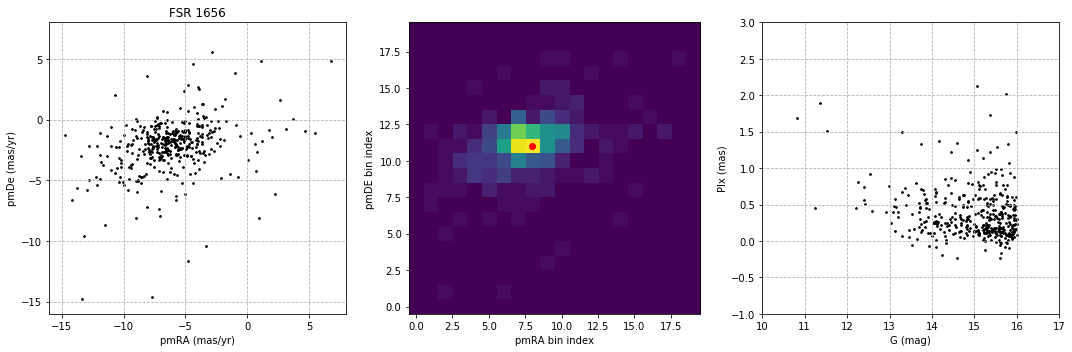

In [37]:
## determine limits for dimensioning the VPD
def pm_limits(pmras, pmdes):
    max_pm = ceil(np.max([np.max(pmras), np.max(pmdes)]) + 1)
    min_pm = floor(np.min([np.min(pmras), np.min(pmdes)]) - 1)
    return min_pm, max_pm
 
def plx_limits(plxs):
    max_plx = ceil(np.max(plxs) + 0.25)
    min_plx = floor(np.min(plxs) - 0.25)
    return min_plx, max_plx

def mag_limits(gmags):
    max_gmag = ceil(np.max(gmags) + 0.5)
    min_gmag = floor(np.min(gmags) - 0.5)
    return min_gmag, max_gmag

# Build a VPD (Vector Proper Motion Diagram) scatter plot
def plot_VPD(data, title):
    pmras = data['pmRA']
    pmdes = data['pmDE']
    xs, ys = pmras, pmdes
    plt.title(title)
    plt.xlabel('pmRA (mas/yr)')
    plt.ylabel('pmDe (mas/yr)')
    min_pm, max_pm = pm_limits(pmras, pmdes)
    plt.xlim(min_pm, max_pm)
    plt.ylim(min_pm, max_pm)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# Calculates the median parallax of the stars within <limit> of the estimated pms
def calculate_estimates(data, est_pmra, est_pmde, limit = 1):
    def filter_pms(pmra, pmde):
        return (abs(est_pmra - pmra) < limit) and (abs(est_pmde - pmde) < limit)
    filter_fn = lambda x: filter_pms(x['pmRA'], x['pmDE'])
    data = data[data.apply(filter_fn, axis = 1)]
    plxs = data['Plx']
    pmra = data['pmRA']
    pmde = data['pmDE']
    gmag = data['Gmag']
    plx, err_plx = np.median(plxs), ap.median_absolute_deviation(plxs)
    pmra, err_pmra = np.median(pmra), ap.median_absolute_deviation(pmra)
    pmde, err_pmde = np.median(pmde), ap.median_absolute_deviation(pmde)
    gmin, gmax = np.min(gmag), np.max(gmag)
    return data, plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, len(plxs)

# Build 2D histogram for proper motions and returns average PMs for the bin with the highest count
def plot_pm_hist(data, num_bins = 20):
    xs = data['pmRA']
    ys = data['pmDE']
    min_pm, max_pm = pm_limits(xs, ys)
    _range = [[min_pm, max_pm], [min_pm, max_pm]]
    counts, xedges, yedges = np.histogram2d(xs, ys, bins = num_bins, range = _range)
    x_ind, y_ind = np.unravel_index(np.argmax(counts), counts.shape)
    est_pmRA = (xedges[x_ind] + xedges[x_ind+1]) / 2
    est_pmDe = (yedges[y_ind] + yedges[y_ind+1]) / 2
    plt.imshow(counts.T, origin = 'lower')
    plt.xlabel('pmRA bin index')
    plt.ylabel('pmDE bin index')
    plt.plot(x_ind, y_ind, 'or')
    #stars, plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n = calculate_estimates(data, est_pmRA, est_pmDe)
    #return plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n
    return calculate_estimates(data, est_pmRA, est_pmDe)

# Build G mag X Parallax scatter plot
def plot_mag_par(data):
    plxs = data['Plx']
    gmags = data['Gmag']
    min_gmag, max_gmag = mag_limits(gmags)
    min_plx, max_plx = plx_limits(plxs)
    xs, ys = gmags, plxs
    plt.xlabel('G (mag)')
    plt.ylabel('Plx (mas)')
    plt.xlim(min_gmag, max_gmag)
    plt.ylim(min_plx, max_plx)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# plot both graphics side-by-side
def plot_step1(data, cl_name):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(131)
    plot_VPD(data, cl_name)
    plt.subplot(132)
    stars, plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n = plot_pm_hist(data)
    plt.subplot(133)
    plot_mag_par(data)
    plt.tight_layout()
    return stars, plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n

stars, est_plx, err_plx, est_pmRA, err_pmRA, est_pmDe, err_pmDe, gmin, gmax, n = plot_step1(df, cl_name)
estimates = f'{cl_name:<22}; {cl_ra:9.6f}; {cl_de:+9.6f}; {radius:8.5f};  '
estimates += f'{est_plx:5.3f}; {err_plx:5.3f}; {est_pmRA:6.2f};{err_pmRA:6.2f}; {est_pmDe:6.2f};{err_pmDe:6.2f};'
estimates += f'{n:>5}; {gmin:5.2f}..{gmax:5.2f}'
print(estimates)

## 3.5 - Build DECAPS query

In [52]:
decaps_query = '''
SELECT
  gaia2.id1,
  gaia2.ra1,
  gaia2.dec1,
  decaps.median_mag_g,
  decaps.median_mag_g_r,
  decaps.median_mag_i,
  decaps.median_mag_i_z,
  decaps.median_mag_r,
  decaps.median_mag_r_i,
  decaps.median_mag_y,
  decaps.median_mag_z,
  decaps.median_mag_z_y
FROM
  decaps_dr1.object decaps
  INNER JOIN gaia_dr2.x1p5__gaia_source__decaps_dr1__object gaia2 ON decaps.obj_id = gaia2.id2
WHERE
  gaia2.id1 IN (%s)
'''

#isochrones (PARSEC): http://stev.oapd.inaf.it/cgi-bin/cmd
# run in https://datalab.noao.edu/query.php?name=gaia_dr2.x1p5__gaia_source__decaps_dr1__object
def build_decaps_query(_df):
    ids = ',\n  '.join([idx.decode('utf-8').replace('Gaia DR2','').strip() for idx in _df.index.values.tolist()])
    return decaps_query % ids

#print(stars)
print(build_decaps_query(stars))


SELECT
  gaia2.id1,
  decaps.median_mag_g,
  decaps.median_mag_g_r,
  decaps.median_mag_i,
  decaps.median_mag_i_z,
  decaps.median_mag_r,
  decaps.median_mag_r_i,
  decaps.median_mag_y,
  decaps.median_mag_z,
  decaps.median_mag_z_y
FROM
  decaps_dr1.object decaps
  INNER JOIN gaia_dr2.x1p5__gaia_source__decaps_dr1__object gaia2 ON decaps.obj_id = gaia2.id2
WHERE
  gaia2.id1 IN (5522814092777276032,
  5522814097078663040,
  5522814097078661504,
  5522814092774877312,
  5522814165793774464,
  5522814092773997312,
  5522814097078667264,
  5522814092773992192,
  5522814092773991168,
  5522814470731126016,
  5522814131438395904,
  5522802346048147456,
  5522814127133755520,
  5522814127134614784,
  5522814131438396416,
  5522802719701114112,
  5522814470731124864,
  5522802311688407168,
  5522802346048152064,
  5522814333292684672)



## 4 - Query another area constrained by the estimated values

In [47]:
def constrained_query(name, ra_deg, de_deg, rad, est_pmRA, est_pmDe, est_plx, mul_pm=4, mul_px=4, mul_rad=1):
    plx_lim = (est_plx - mul_px*err_plx, est_plx + mul_px*err_plx)
    plx_range = f'{plx_lim[0]:.2f}..{plx_lim[1]:.2f}'
    pmRA_lim = (est_pmRA - mul_pm*err_pmRA, est_pmRA + mul_pm*err_pmRA)
    pmRA_range = f'{pmRA_lim[0]:.2f}..{pmRA_lim[1]:.2f}'
    pmDe_lim = (est_pmDe - mul_pm*err_pmDe, est_pmDe + mul_pm*err_pmDe)
    pmDe_range = f'{pmDe_lim[0]:.2f}..{pmDe_lim[1]:.2f}'
    gmag_range = f'{gmin:.2f}..{gmax:.2f}'
    filters2 = {'Plx' : plx_range, 'pmRA' : pmRA_range, 'pmDE' : pmDe_range, 'Gmag' : gmag_range}
    #print(filters2)
    return query(name, ra_deg, de_deg, rad*mul_rad, filters2, max_stars = row_lim)
    
#df2 = constrained_query(cl_name, cl_ra, cl_de, radius, est_pmRA, est_pmDe, est_plx)
#df2.head
#display(HTML(df2.to_html()))

#plot_step1(df2, cl_name)

## 5 - Chart  and RDP scatter plot (constrained by the estimated values)

In [ ]:

# Build chart scatter plot
def plot_chart(data, title):
    xs, ys = data['_RAJ2000'], data['_DEJ2000']
    plt.title(title)
    plt.xlabel('RA (degrees)')
    plt.ylabel('De (degrees)')
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# Build RDP (Radial Density Profile) scatter plot
def plot_RDP(data, title = None):
    bins = data['_r'].value_counts(bins=25).sort_index()
    intervals = bins.index.to_tuples()
    midpoints = [i.mid for i in bins.index]
    counts = bins.values
    zipped = tuple(zip(intervals, midpoints, counts))
    densities = [count / ring_area(inner*60, outer*60) for ((inner, outer), midpoint, count) in zipped]
    log_dens = [np.log10(dens) if dens > 0 else 0 for dens in densities]
    print(bins)
    #print(intervals)
    #print(midpoints)
    #print(counts)
    #print(zipped)
    plt.grid(True, linestyle='dashed')
    plt.title(title)
    plt.xlabel('Radius (degrees)')
    plt.xticks([i for i,j in intervals], rotation='vertical')
    plt.ylabel('Logarithm of Star Density (stars/arcmin^2)')
    plt.scatter(midpoints, log_dens, s=6, color='black')

# plot both graphics side-by-side
def plot_step2(data, cl_name):
    fig = plt.figure(figsize=(15,6))
    plt.subplot(121)
    plot_chart(data, cl_name)
    plt.subplot(122)
    plot_RDP(data, cl_name)
    plt.tight_layout()

def ring_area(inner_rad, outer_rad):
    return pi * (outer_rad**2 - inner_rad**2)
    
plot_step2(df2, cl_name)


## 6 - CMD

In [ ]:
# Build G mag X Parallax scatter plot
def plot_mag_par(data, title = None):
    plxs = data['Plx']
    gmags = data['Gmag']
    min_gmag, max_gmag = mag_limits(gmags)
    min_plx, max_plx = plx_limits(plxs)
    xs, ys = gmags, plxs
    if title:
        plt.title(title)
    plt.xlabel('G (mag)')
    plt.ylabel('Plx (mas)')
    plt.xlim(min_gmag, max_gmag)
    plt.ylim(min_plx, max_plx)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# Build CMD (Color-Magnitude Diagram) scatter plot
def plot_CMD(data, title = None):
    gmags = data['Gmag']
    colors = data['BP-G']
    min_gmag, max_gmag = mag_limits(gmags)
    min_color, max_color = mag_limits(colors)
    xs, ys = colors, gmags
    if title:
        plt.title(title)
    plt.xlabel('BP-G (mag)')
    plt.ylabel('G (mag)')
    plt.xlim(min_color, max_color)
    plt.ylim(max_gmag, min_gmag)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

chosen_lim_radius = 1.15 #choose one based on the RDP printed above
df3 = df2[df2['_r'] < chosen_lim_radius]
#plot_mag_par(df3, cl_name)
plot_CMD(df3, cl_name)
